In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib as plt

2022-02-12 21:59:14.504423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 21:59:14.504448: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pandas as pd
from preprocess import Preprocess
import logging
import torch
import re
from dataset import STSDataset
from datasets import load_dataset,Dataset
import spacy
import torchtext
from torchtext.data import get_tokenizer
from spacy.lang.en import English
from torchtext.legacy.data import Field
from torch.utils.data import DataLoader
import numpy as np

In [4]:
# dataset = load_dataset('text', data_files='SICK.txt')
# dataset
columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
stopwords_path="stopwords-en.txt"
columns_mapping.values()

dict_values(['sentence_A', 'sentence_B', 'relatedness_score'])

In [5]:
sick_dataset = load_dataset('sick',download_mode='reuse_cache_if_exists')
sick_dataset=sick_dataset.remove_columns(['label','id','entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'])
train_pd=pd.DataFrame.from_dict(sick_dataset['train'])
validation_pd=pd.DataFrame.from_dict(sick_dataset['validation'])
test_pd=pd.DataFrame.from_dict(sick_dataset['test'])
sick_data=[train_pd,validation_pd,test_pd]
# sick_df = pd.DataFrame(data=sick_dataset.data, columns=sick_dataset.column_names)
# sen_A=columns_mapping['sent1']
# sen_B= columns_mapping['sent2']
# score=columns_mapping['label']
# sick_df=sick_df[[sen_A,sen_B,score]]
# pd.read_csv(dataset)

Dataset sick downloaded and prepared to /home/ibrahimssd/.cache/huggingface/datasets/sick/default/0.0.0/c6b3b0b44eb84b134851396d6d464e5cb8f026960519d640e087fe33472626db. Subsequent calls will reuse this data.


In [84]:
# sick_dataset['train']
# Dataset.from_pandas(tran_pd)
splits= list(sick_dataset.keys())
type(sick_dataset)
len(train_data_df)
4439/64

69.359375

In [7]:
import re
import string

"""
Performs basic text cleansing on the unstructured field 
"""


class Preprocess:
    def __init__(self, stpwds_file_path):
        """
        Initializes regex patterns and loads stopwords
        """
        # TODO implement
        with open(stpwds_file_path) as fh:
            self.stopwords=list(set(fh.read().split()))
        self.noise_re = re.compile('\\b(%s)\\W'%('|'.join(map(re.escape,self.stopwords))),re.I)
    

    def perform_preprocessing(self, data, columns_mapping):
        sen_A=columns_mapping['sent1']
        sen_B= columns_mapping['sent2']
        score=columns_mapping['label']
        cleaned_data=[]
        for data_frame in data:
            groupA=list(data_frame[sen_A])
            groupB=list(data_frame[sen_B])
            ## normalize text to lower case
            groupA=[x.lower() for x in groupA]
            groupB=[x.lower() for x in groupB]
            ## remove punctuations
            groupA=[''.join(c for c in x if c not in string.punctuation) for x in groupA]
            groupB=[''.join(c for c in x if c not in string.punctuation) for x in groupB]
            ## remove stopwords
            groupA=[self.noise_re.sub('',p) for p in groupA]
            groupB=[self.noise_re.sub('',p) for p in groupB]
            # Trim extra whitespace
            groupA=[' '.join(x.split()) for x in groupA]
            groupB=[' '.join(x.split()) for x in groupB]
            # Remove numbers
            groupA=[''.join(c for c in x if c not in '0123456789') for x in groupA]
            groupB=[''.join(c for c in x if c not in '0123456789') for x in groupB]
            ## return data_back to DataFrame
            data_frame[sen_A]=groupA
            data_frame[sen_B]=groupB
            cleaned_data.append(data_frame)
        
        
        sick_dataset={'train':Dataset.from_pandas(cleaned_data[0]),
                      'validation':Dataset.from_pandas(cleaned_data[1]),
                      'test':Dataset.from_pandas(cleaned_data[2])}
        data_frame=pd.concat(cleaned_data, ignore_index=True)
        
        return sick_dataset


In [8]:
process=Preprocess(stopwords_path)
formatted_data=process.perform_preprocessing(sick_data,columns_mapping)


In [9]:
train_data= pd.DataFrame(formatted_data['train'])

In [10]:
cols = list(columns_mapping.values())
cols.pop()
sen_list=list(train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
sen_str = ' '.join(map(str, sen_list))
print(len(sen_list))

4439


In [11]:
# Word tokenization
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
text = """When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!"""

#  "nlp" Object is used to create documents with linguistic annotations.
my_doc = nlp(sen_str)

# Create list of word tokens
token_list = []
for token in my_doc:
    token_list.append(token.text)
# print(token_list)

In [12]:
from torchtext.vocab import vocab
from collections import Counter, OrderedDict
counter = Counter(token_list)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
v= vocab(ordered_dict)

PAD_token = 0   # Used for padding short sentences
SOS_token = 1   # Start-of-sentence token
EOS_token = 2   # End-of-sentence token
special_words={PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
default_index = -1
v.set_default_index(default_index)
for key , value in special_words.items():
    if value not in v: v.insert_token(value, key)



In [13]:
with open(stopwords_path) as fh:
            stopwords=list(set(fh.read().split()))

In [14]:
train_data['sentenceA&B']=train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [15]:
text_field = Field(
#     tokenize='basic_english', 
    lower=True,
    include_lengths=True,
    pad_token='PAD',
    pad_first='SOS',
    stop_words=stopwords,
)

# label_field = Field(sequential=False, use_vocab=False)
preprocessed_text = train_data['sentenceA&B'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(
    preprocessed_text, 
    vectors='fasttext.simple.300d')

# get the vocab instance
vocab = text_field.vocab

INFO:torchtext.vocab:Loading vectors from .vector_cache/wiki.simple.vec.pt


In [16]:
preprocessed_text
len(vocab.itos)

1962

In [17]:
# def data2tensors(self, data):
#         """
#         Converts raw data sequences into vectorized sequences as tensors
#         """
#         pass
#         # TODO implement

# def get_data_loader(self, batch_size=8):
#         pass
#         # TODO implement

# def sort_batch(self, batch, targets, lengths):
#         """
#         Sorts the data, lengths and target tensors based on the lengths
#         of the sequences from longest to shortest in batch
#         """
#         sents1_lengths, perm_idx = lengths.sort(0, descending=True)
#         sequence_tensor = batch[perm_idx]
#         target_tensor = targets[perm_idx]
#         return sequence_tensor.transpose(0, 1), target_tensor, sents1_lengths

# def vectorize_sequence(self, sentence):
#         """
#         Replaces tokens with their indices in vocabulary
#         """
#         pass
#         # TODO implement

# def pad_sequences(self, vectorized_sents, sents_lengths):
#         """
#         Pads zeros at the end of each sequence in data tensor till max
#         length of sequence in that batch
#         """
#         pass
#         # TODO implement
# def encode(vocab,string):
#        return vocab[string]
        

In [18]:
# train_data['sentenceA&B'][0].apply(lambda x: print(x) )

In [19]:
def vectorize_sequence(sentence):
        """
        Replaces tokens with their indices in vocabulary
        """
        splited_sentence=sentence.split()
        encodes=[vocab[token] for token in splited_sentence]
        return encodes

In [20]:
cols = list(columns_mapping.values())
cols.pop()
train_data= pd.DataFrame(formatted_data['train'])
val_data=pd.DataFrame(formatted_data['validation'])
test_data=pd.DataFrame(formatted_data['test'])
train_data['sentenceA&B']=train_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_data['sentenceA&B']=val_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_data['sentenceA&B']=test_data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

codes=[]
for sentence in val_data['sentenceA&B']:
    encodes= vectorize_sequence(sentence)
    codes.append(encodes)
val_data['sentenceA&B'] = codes
val_data

,sentence_A,sentence_B,relatedness_score,sentenceA&B
0,boys playing outdoors smiling nearby,boy playing outdoors smiling,3.6,"[51, 4, 111, 133, 1390, 7, 4, 111, 133]"
1,person black jacket tricks motorbike,skilled person riding bicycle wheel,3.4,"[5, 11, 76, 427, 175, 0, 5, 18, 66, 332]"
2,children backbends gym,girls backbends playing outdoors,3.8,"[35, 885, 476, 118, 885, 4, 111]"
3,player throwing ball,teams competing football match,2.9,"[85, 166, 21, 541, 606, 84, 1224]"
4,children standing wooden hut,children standing wooden hut,4.2,"[35, 6, 172, 1071, 35, 6, 172, 1071]"
...,...,...,...,...
490,biker riding fence,dancing road,1.2,"[317, 18, 199, 25, 68]"
491,woman playing electric guitar,kid playing guitar,3.0,"[2, 4, 402, 20, 79, 4, 20]"
492,animal grazing grass,cop sitting police bike,1.0,"[98, 522, 22, 910, 14, 969, 29]"
493,dog snapping droplets water,girl band playing instrument,1.0,"[3, 990, 735, 15, 8, 282, 4, 208]"


In [21]:
def data2tensors(data):
        """
        Converts raw data sequences into vectorized sequences as tensors
        """
        
        
        
        data['sent1_tensor']=data['sent1_tensor'].apply(lambda lis : torch.as_tensor(lis))
        data['sent2_tensor']=data['sent2_tensor'].apply(lambda lis : torch.as_tensor(lis))
           
        
        
        return data
    

In [22]:
# pd.DataFrame(data2tensors(formatted_data)['train'])["sentenceA&B"]

In [23]:
dataloaders = {x:DataLoader(formatted_data[x],32, shuffle=True, num_workers=4) for x in ['train','validation','test']}

In [24]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# train_features, train_labels = next(iter(dataloaders['train']))
# from torch.utils import data
# train_tensor = data.TensorDataset(train_data, train_label)

In [25]:
# from torch.utils import data
# train_tensor = data.TensorDataset(train_data, train_label)

In [26]:
# dataloaders = {'train': torch.utils.data.DataLoader(STSDataset(sts_train_df, batch_size=64)),
#                'val': torch.utils.data.DataLoader(STSDataset(sts_dev_df, batch_size=64))}


In [27]:
# train_target = torch.tensor(train['Target'].values.astype(np.float32))
# train = torch.tensor(train.drop('Target', axis = 1).values.astype(np.float32)) 
# train_tensor = data_utils.TensorDataset(train, train_target) 
# train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [28]:
train_data_df= pd.DataFrame(formatted_data['train'])
val_data_df=pd.DataFrame(formatted_data['validation'])
test_data_df=pd.DataFrame(formatted_data['test'])

In [29]:
train_data_df['sent1_tensor']=train_data_df['sentence_A'].apply(lambda sen: vectorize_sequence(sen))
train_data_df['sent2_tensor']=train_data_df['sentence_B'].apply(lambda sen: vectorize_sequence(sen))

In [30]:
# train_data_df = torch.tensor(train_data_df['sentence_A'].values.astype(np.float32))
train_data_df=data2tensors(train_data_df)
train_data_df['sents1_length_tensor']=train_data_df['sent1_tensor'].apply(lambda tensor : torch.tensor(len(tensor)))
train_data_df['sents2_length_tensor']=train_data_df['sent2_tensor'].apply(lambda tensor : torch.tensor(len(tensor)))

In [31]:
#import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# padded=pad_sequences(train_data_df['sent1_tensor'],padding="post",truncating=”post”,maxlen=8)


In [32]:
def pad_sequences(sequences):
        """
        :param sequences: list of tensors
        :return:
        """
        num = len(sequences)
        max_len = max([s.shape[0] for s in sequences])
        out_dims = (num, max_len, *sequences[0].shape[1:])
        out_tensor = sequences[0].data.new(*out_dims).fill_(0)
        mask = sequences[0].data.new(*out_dims).fill_(0)
        for i, tensor in enumerate(sequences):
            length = tensor.size(0)
            out_tensor[i, :length] = tensor
            mask[i, :length] = 1
        return list(out_tensor)

In [33]:
train_data_df['sent1_tensor']=pad_sequences(train_data_df['sent1_tensor'])
train_data_df['sent2_tensor']=pad_sequences(train_data_df['sent2_tensor'])

In [34]:
train_data_df['relatedness_score']=train_data_df['relatedness_score'].apply(lambda score : torch.tensor(score/sum(train_data_df['relatedness_score'])))

In [35]:
"""
Standard Pytorch Dataset class for loading datasets.
"""


class STSDataset(Dataset):
    def __init__(
        self,
        sent1_tensor,
        sent2_tensor,
        target_tensor,
        sents1_length_tensor,
        sents2_length_tensor,
        raw_sents_1,
        raw_sents_2,
    ):
        """
        initializes  and populates the the length, data and target tensors, and raw texts list
        """
        
        assert (
            
            
            len(sent1_tensor)
            == torch.tensor(list(target_tensor)).size(0)
            == len(sent2_tensor)
            == torch.tensor(list(sents1_length_tensor)).size(0)
            == torch.tensor(list(sents2_length_tensor)).size(0)
        )
        self.sent1_tensor = sent1_tensor
        self.sent2_tensor = sent2_tensor
        self.target_tensor = target_tensor
        self.sents1_length_tensor = sents1_length_tensor
        self.sents2_length_tensor = sents2_length_tensor
        self.raw_sents_1 = raw_sents_1
        self.raw_sents_2 = raw_sents_2

    def __getitem__(self, index):
        """
        returns the tuple of data tensor, targets, lengths of sequences tensor and raw texts list
        """
        return (
            self.sent1_tensor[index],
            self.sent2_tensor[index],
            self.sents1_length_tensor[index],
            self.sents2_length_tensor[index],
            self.target_tensor[index],
            self.raw_sents_1[index],
            self.raw_sents_2[index],
        )

    def __len__(self):
        """
        returns the length of the data tensor.
        """
        return torch.tensor(list(self.target_tensor)).size(0)


In [36]:
train_data_df                       

,sentence_A,sentence_B,relatedness_score,sent1_tensor,sent2_tensor,sents1_length_tensor,sents2_length_tensor
0,kids playing yard standing background,boys yard playing standing background,tensor(0.0003),"[tensor(65), tensor(4), tensor(144), tensor(6)...","[tensor(51), tensor(144), tensor(4), tensor(6)...",tensor(5),tensor(5)
1,children playing house standing background,kids playing yard standing background,tensor(0.0002),"[tensor(35), tensor(4), tensor(403), tensor(6)...","[tensor(65), tensor(4), tensor(144), tensor(6)...",tensor(5),tensor(5)
2,boys playing outdoors smiling nearby,kids playing outdoors smile,tensor(0.0003),"[tensor(51), tensor(4), tensor(111), tensor(13...","[tensor(65), tensor(4), tensor(111), tensor(86...",tensor(5),tensor(4)
3,kids playing outdoors smile,kids playing yard standing background,tensor(0.0002),"[tensor(65), tensor(4), tensor(111), tensor(86...","[tensor(65), tensor(4), tensor(144), tensor(6)...",tensor(4),tensor(5)
4,boys playing outdoors smiling nearby,kids playing yard standing background,tensor(0.0002),"[tensor(51), tensor(4), tensor(111), tensor(13...","[tensor(65), tensor(4), tensor(144), tensor(6)...",tensor(5),tensor(5)
...,...,...,...,...,...,...,...
4434,door man,bald band playing guitar spotlight,tensor(7.0483e-05),"[tensor(349), tensor(0), tensor(0), tensor(0),...","[tensor(1480), tensor(282), tensor(4), tensor(...",tensor(2),tensor(5)
4435,boiling okra pot,playing drums,tensor(6.4075e-05),"[tensor(187), tensor(359), tensor(86), tensor(...","[tensor(4), tensor(339), tensor(0), tensor(0),...",tensor(3),tensor(2)
4436,singing heartily playing guitar,bicyclist holding bike head people,tensor(6.4075e-05),"[tensor(47), tensor(1555), tensor(4), tensor(2...","[tensor(273), tensor(27), tensor(29), tensor(2...",tensor(4),tensor(5)
4437,blue yellow ball mitt,jumping rope outside,tensor(7.6890e-05),"[tensor(24), tensor(39), tensor(21), tensor(13...","[tensor(16), tensor(60), tensor(0), tensor(0),...",tensor(4),tensor(3)


In [37]:
train_dataset=  STSDataset(train_data_df['sent1_tensor'],
                         train_data_df['sent2_tensor'],
                         train_data_df['relatedness_score'],
                         train_data_df['sents1_length_tensor'],
                         train_data_df['sents2_length_tensor'],
                         train_data_df['sentence_A'],
                         train_data_df['sentence_B']
                         )

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [38]:
# len(train_data_df['sent1_tensor'])
# train_data_df['sents1_length_tensor'].size()
# torch.tensor(list(target_tensor)).size(0)
# train_data_df['sent1_tensor'][0]
# train_data_df['relatedness_score'][0]
# train_data_df['sents1_length_tensor'][0]
# train_data_df['sentence_A'][0]

In [39]:
train_data_df['relatedness_score'][0].size()

torch.Size([])

In [40]:
train_loader

In [41]:
dataiter = iter(train_loader)
len(dataiter.next())

7

In [42]:
for batch in train_loader:
    print(batch)
    break

[tensor([[   2,  187,  254,   15,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  53,  163,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  33,   12,  510,   55,   21,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   9,  145,  290,  461,   15,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   28,  799,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   8,   74, 1935,   16,   38,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  371,   63,   49,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  85,   55,  983,  221,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  47,    4,   20,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  66,  159,    0,    0,    0,    0,    0,    0,    0,    0,    

In [43]:
batch[0]

tensor([[   2,  187,  254,   15,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  53,  163,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  33,   12,  510,   55,   21,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   9,  145,  290,  461,   15,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   28,  799,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   8,   74, 1935,   16,   38,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  371,   63,   49,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  85,   55,  983,  221,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  47,    4,   20,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  66,  159,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [44]:
n, d, m = 3, 5, 7
embedding = torch.nn.Embedding(n, d, max_norm=True)
W = torch.randn((m, d), requires_grad=True)
idx = torch.tensor([1, 2])
# a = embedding.weight.clone() @ W.t()  # weight must be cloned for this to be differentiable
# b = embedding(idx) @ W.t()  # modifies weight in-place
# out = (a.unsqueeze(0) + b.unsqueeze(1))
# loss = out.sigmoid().prod()
# loss.backward()

In [45]:
embedding(idx)

tensor([[ 0.3916, -0.5480,  0.4557,  0.3674, -0.4514],
        [-0.4319, -0.0970,  0.3629,  0.6893,  0.4441]],
       grad_fn=<EmbeddingBackward>)

In [46]:
vocab_size= len(vocab)
embedding_size= 300

In [47]:
embedding = torch.nn.Embedding(vocab_size, embedding_size, max_norm=True)

In [48]:
sen=torch.tensor([[121,  82,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 36,   4, 404,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [49]:
embedding(sen).size()

torch.Size([2, 14, 300])

In [50]:
vocab.vectors[sen]

tensor([[[ 0.2267,  0.0823, -0.0737,  ...,  0.2816,  0.0708, -0.1727],
         [ 0.2845, -0.0039,  0.3620,  ..., -0.2849,  0.0120, -0.0268],
         [ 0.2008, -0.0394,  0.3176,  ...,  0.0508, -0.2701, -0.2984],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1809, -0.3359, -0.2671,  ..., -0.1251,  0.1333, -0.3796],
         [ 0.3038,  0.4029,  0.6689,  ..., -0.2629, -0.1546, -0.4536],
         [ 0.0527, -0.0633, -0.4662,  ...,  0.3418, -0.0439, -0.1786],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [51]:
embedding_weights= vocab.vectors
net = torch.nn.LSTM(10, 20, 1)

In [52]:
def similarity_score(input1, input2):
    # Get similarity predictions:
    dif = input1.squeeze() - input2.squeeze()

    norm = torch.norm(dif, p=1, dim=dif.dim() - 1)
    y_hat = torch.exp(-norm)
    y_hat = torch.clamp(y_hat, min=1e-7, max=1.0 - 1e-7)
    return y_hat


In [53]:
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64
sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...


Dataset sick downloaded and prepared to /home/ibrahimssd/.cache/huggingface/datasets/sick/default/0.0.0/c6b3b0b44eb84b134851396d6d464e5cb8f026960519d640e087fe33472626db. Subsequent calls will reuse this data.


INFO:root:reading and preprocessing data completed...
INFO:root:creating vocabulary...
INFO:torchtext.vocab:Loading vectors from .vector_cache/wiki.simple.vec.pt
INFO:root:creating vocabulary completed...


In [54]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils import similarity_score


"""
Wrapper class using Pytorch nn.Module to create the architecture for our model
Architecture is based on the paper: 
A STRUCTURED SELF-ATTENTIVE SENTENCE EMBEDDING
https://arxiv.org/pdf/1703.03130.pdf
"""


class SiameseBiLSTMAttention(nn.Module):
    def __init__(
        self,
        batch_size,
        output_size,
        hidden_size,
        vocab_size,
        embedding_size,
        embedding_weights,
        lstm_layers,
        device,
        bidirectional,
        self_attention_config,
        fc_hidden_size,
    ):
        super(SiameseBiLSTMAttention, self).__init__()
        """
        Initializes model layers and loads pre-trained embeddings from task 1
        """
        ## model hyper parameters
        self.batch_size = batch_size
        self.output_size = output_size
        self.lstm_hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.lstm_layers = lstm_layers
        self.device = device
        self.bidirectional = bidirectional
        self.fc_hidden_size = fc_hidden_size
        self.lstm_directions = (
            2 if self.bidirectional else 1
        )  ## decide directions based on input flag
        
        
        
        ## model layers
        # TODO initialize the look-up table.
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        # TODO assign the look-up table to the pre-trained fasttext word embeddings.
        
        self.lookup= embedding_weights   #self.embeddings
        
        ## TODO initialize lstm layer
        self.bi_lstm = torch.nn.LSTM(self.embedding_size, self.lstm_hidden_size, 
                            lstm_layers, batch_first=True , bias= True,bidirectional=True)
        
        ## TODO initialize self attention layers
        self.SelfAtt= SelfAttention(2*self.lstm_hidden_size, self_attention_config['hidden_size'],
                                    self_attention_config['output_size'])
        
        #Initialize fully connected layer
        self.fc = nn.Linear(2*self.lstm_hidden_size * self_attention_config['output_size'], self.fc_hidden_size )
        self.tanh = nn.Tanh()
        ## incase we are using bi-directional lstm we'd have to take care of bi-directional outputs in
        ## subsequent layers
        
        

    def init_hidden(self, batch_size):
        """
        Initializes hidden and context weight matrix before each
                forward pass through LSTM
        """
        h0 = torch.randn(self.lstm_directions*self.lstm_layers, batch_size, self.lstm_hidden_size)
        c0 = torch.randn(self.lstm_directions*self.lstm_layers, batch_size, self.lstm_hidden_size)
        
        return h0, c0 

    def forward_once(self, batch, lengths):
        """
        Performs the forward pass for each batch
        """

        ## batch shape: (batch_size, seq_len)
        batch_size , sequence_len = batch.size()
        ## embeddings shape: ( batch_size, seq_len, embedding_size)
        
        #h_init,c_init = self.init_hidden(batch_size)
        input_batch_sequences= self.lookup[batch]
        
        output, (hn, cn) = self.bi_lstm(input_batch_sequences, (self.h_init, self.c_init))

        return output , (hn , cn)

    def forward(self, sent1_batch, sent2_batch, sent1_lengths, sent2_lengths):
        """
        Performs the forward pass for each batch
        """
        
        
        ## init context and hidden weights for lstm cell
        self.h_init,self.c_init = self.init_hidden(self.batch_size)
        output1,_ = self.forward_once(sent1_batch,sent1_lengths)
        self.h_init,self.c_init = self.init_hidden(self.batch_size)
        output2,_ = self.forward_once(sent2_batch,sent2_lengths)
        
        ## Self attention Layer
        attended_embeddings_sent1, attention_matrix_sent1 = self.SelfAtt.forward(output1)
        attended_embeddings_sent2, attention_matrix_sent2 = self.SelfAtt.forward(output2)
        
        ## Fully connected layer 
        
        final_embeddings_sent1= self.tanh(self.fc(attended_embeddings_sent1.reshape(output1.size(0),-1)))
        final_embeddings_sent2= self.tanh(self.fc(attended_embeddings_sent2.reshape(output2.size(0),-1)))
        
        
        #similarity score prediction
        predictions = similarity_score(final_embeddings_sent1, final_embeddings_sent2)
        
        print(torch.cat((attention_matrix_sent1, attention_matrix_sent2), 1).size())
        return predictions , 

class SelfAttention(nn.Module):
    """
    Implementation of the attention block
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SelfAttention, self).__init__()
        # TODO implement
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.ws1 = nn.Linear(input_size, hidden_size, bias=False)
        self.ws2 = nn.Linear(hidden_size, output_size, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        
        
    ## the forward function would receive lstm's all hidden states as input
    def forward(self, attention_input):
        # TODO implement
        #pass
        
        size = attention_input.size()
        inp = attention_input.reshape(size[0]*size[1],size[2])
        attention_matrix = self.softmax(self.ws2(self.tanh(self.ws1(inp))))
        attention_matrix= attention_matrix.reshape(size[0], self.output_size, -1)
        attended_embeddings_sent1= torch.bmm(attention_matrix , attention_input)
        
        return attended_embeddings_sent1, attention_matrix

In [55]:
batch_size = 64
output_size = 1
hidden_size = 128
vocab_size = len(vocab)
embedding_size = 300
embedding_weights = vocab.vectors
lstm_layers = 4
learning_rate = 1e-1
fc_hidden_size = 64
max_epochs = 5
bidirectional = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## self attention config
self_attention_config = {
    "hidden_size": 150,  ## refers to variable 'da' in the ICLR paper
    "output_size": 20,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.0,  ## refers to penalty coefficient term in the ICLR paper
}

In [56]:
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
)
## move model to device
optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters())
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (embeddings): Embedding(1962, 300)
  (bi_lstm): LSTM(300, 128, num_layers=4, batch_first=True, bidirectional=True)
  (SelfAtt): SelfAttention(
    (ws1): Linear(in_features=256, out_features=150, bias=False)
    (ws2): Linear(in_features=150, out_features=20, bias=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
  )
  (fc): Linear(in_features=5120, out_features=64, bias=True)
  (tanh): Tanh()
)

In [57]:
siamese_lstm_attention.forward(batch[0],batch[1],7,4)

torch.Size([64, 40, 14])


/home/ibrahimssd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor([0.3208, 0.2469, 0.3409, 0.3280, 0.3510, 0.3162, 0.3752, 0.3889, 0.3286,
         0.2408, 0.3983, 0.2968, 0.3417, 0.3010, 0.4053, 0.3349, 0.2852, 0.3299,
         0.3505, 0.2940, 0.3519, 0.2892, 0.3620, 0.2359, 0.3191, 0.3963, 0.2952,
         0.3042, 0.3244, 0.3142, 0.3722, 0.2982, 0.2970, 0.2820, 0.2952, 0.3185,
         0.3692, 0.2766, 0.3553, 0.3955, 0.3946, 0.2812, 0.3229, 0.3506, 0.3468,
         0.3425, 0.4210, 0.2896, 0.3079, 0.3460, 0.3980, 0.3299, 0.3534, 0.3295,
         0.2843, 0.4037, 0.4177, 0.3238, 0.3244, 0.3301, 0.3451, 0.3137, 0.3332,
         0.3395], grad_fn=<ClampBackward1>),)

In [58]:
import torch
from torch import nn
import logging
from tqdm import tqdm
from torch.autograd import Variable


logging.basicConfig(level=logging.INFO)

"""
Script for training the neural network and saving the better models 
while monitoring a metric like accuracy etc
"""


def train_model(model, optimizer, dataloader, data, max_epochs, config_dict):
    device = config_dict["device"]
    criterion = nn.MSELoss()
    max_accuracy = 5e-1
    train_loader , val_loader , test_loader = dataloader
    dictionary_info={}
    for epoch in tqdm(range(max_epochs)):
        
        try:
            # Samples the batch
            sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(iter(dataloader))

        except StopIteration:
            # restart the generator if the previous generator is exhausted.
            train_generator = iter(train_loader)
            sent1_batch, sent2_batch, sent1_lengths, sent2_lengths,targets,raw_sent1,raw_sent2= next(iter(dataloader))
        
        
        predictions , attention_matrix = model.forward(sent1_batch, sent2_batch, sent1_lengths, sent2_lengths)
        optimizer.zero_grad()
        
        try:
             train_loss = criterion(predictions,targets) + attention_penalty_loss(attention_matrix, 
                                                                  config_dict['self_attention_config']['penalty'], device)
                       
        except RuntimeError:
            
            raise Exception("Model Loss gets nan values on regularization.Either remove regularization or add very small values")
        
        optimizer.step()
        
        # TODO: computing accuracy using sklearn's function
        ## acc = 
        #accuracy = (torch.argmax(predictions, axis=-1) == targets).float().mean()
        
        acc=accuracy_score(targets, predictions)
        
        ## compute model metrics on dev set
        val_acc, val_loss = evaluate_dev_set(
            model, data, criterion, dataloader, config_dict, device
        )

        
        
        if val_acc > max_accuracy:
            max_accuracy = val_acc
            logging.info(
                "new model saved")  
            
            ## save the model if it is better than the prior best
            torch.save(model.state_dict(), "{}.pth".format(config_dict["model_name"]))

        logging.info(
            "Train loss: {} - acc: {} -- Validation loss: {} - acc: {}".format(
                torch.mean(train_loss.data.float()), acc, val_loss, val_acc
            )
        )
        
        if epoch % 100 == 0:
              print('[%d/%d] loss: %.3f, accuracy: %.3f' %
                   (i , max_epochs - 1, loss.item(), acc.item()))
        if epoch == max_epochs - 1:
               print('Final accuracy: %.3f, expected %.3f' %
                         (accuracy.item(), 1.0))
        
    return model


def evaluate_dev_set(model, data, criterion, data_loader, config_dict, device):
    """
    Evaluates the model performance on dev data
    """
    logging.info("Evaluating accuracy on dev set")

    # TODO implement
    pass

def attention_penalty_loss(annotation_weight_matrix, penalty_coef, device):
    """
    This function computes the loss from annotation/attention matrix
    to reduce redundancy in annotation matrix and for attention
    to focus on different parts of the sequence corresponding to the
    penalty term 'P' in the ICLR paper
    ----------------------------------
    'annotation_weight_matrix' refers to matrix 'A' in the ICLR paper
    annotation_weight_matrix shape: (batch_size, attention_out, seq_len)
    """
    
    batch_size, attention_out_size = annotation_weight_matrix.size(0), annotation_weight_matrix.size(1)
    annotation_weight_matrix_trans = torch.transpose(annotation_weight_matrix, 0, 1)
    identity = torch.eye(annotation_weight_matrix.size(0))
    annotation_mul_difference=annotation_weight_matrix@annotation_weight_matrix_trans - identity
    penalty = frobenius_norm(annotation_mul_difference)
    return penalty_coef*penalty


def frobenius_norm(annotation_mul_difference):
    """
    Computes the frobenius norm of the annotation_mul_difference input as matrix
    """
   
    """
    
 
    Args:
      annotation_mul_difference= ||AAT - I||
 
    Returns:
            regularized value
 
       
        """
    
#    torch.norm(annotation_mul_difference.float(), p='fro')
#     torch.sum(torch.sum(torch.sum(annotation_mul_difference**2,1),1)**0.5).type(torch.DoubleTensor)
    return torch.sqrt(torch.sum(annotation_mul_difference**2))

In [59]:
siamese_lstm_attention = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=train_loader,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

ValueError: too many values to unpack (expected 3)

In [60]:
train_dataset=  STSDataset(train_data_df['sent1_tensor'],
                         train_data_df['sent2_tensor'],
                         train_data_df['relatedness_score'],
                         train_data_df['sents1_length_tensor'],
                         train_data_df['sents2_length_tensor'],
                         train_data_df['sentence_A'],
                         train_data_df['sentence_B']
                         )

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [61]:
# main training loop
# train_loader , val_loader , test_loader = sick_dataloaders
train_generator = iter(train_loader)
for i in range(100):
    try:
        # Samples the batch
        sent1_batch, sent2_batch, sent1_lengths, sent2_lengths, targets,raw_sent1,raw_sent2= next(train_generator)
        print(Variable(targets))
        break
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        train_generator = iter(train_loader)
        sent1_batch, sent2_batch, sent1_lengths, sent2_lengths, targets,raw_sent1,raw_sent2= next(train_generator)

tensor([1.1534e-04, 7.6890e-05, 3.2038e-04, 1.2815e-04, 2.3708e-04, 2.1786e-04,
        2.4349e-04, 1.9223e-04, 7.0483e-05, 2.1145e-04, 2.1786e-04, 2.2426e-04,
        3.2038e-04, 2.9475e-04, 2.4349e-04, 1.0252e-04, 2.4989e-04, 2.9475e-04,
        1.6660e-04, 2.4349e-04, 6.4075e-05, 2.4989e-04, 2.8834e-04, 2.9475e-04,
        2.1145e-04, 2.5630e-04, 3.0756e-04, 1.9223e-04, 2.0504e-04, 1.7941e-04,
        2.8834e-04, 2.6912e-04, 3.2038e-04, 1.9863e-04, 6.4075e-05, 2.3708e-04,
        3.1397e-04, 1.1534e-04, 2.6912e-04, 2.0504e-04, 2.1145e-04, 2.5630e-04,
        2.3708e-04, 1.6660e-04, 2.4349e-04, 2.1786e-04, 2.2010e-04, 1.0252e-04,
        1.2815e-04, 2.1786e-04, 2.0504e-04, 2.1145e-04, 1.8582e-04, 1.4737e-04,
        3.0756e-04, 2.1561e-04, 3.0756e-04, 2.6912e-04, 2.5630e-04, 2.9475e-04,
        2.4989e-04, 1.9223e-04, 2.4349e-04, 3.1397e-04])


In [62]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])

In [63]:
vocab.vectors[input]
embedding = nn.Embedding(len(vocab), 300)
embedding(input)

tensor([[[-0.6529, -1.5669, -1.4430,  ...,  0.0196,  1.2238,  1.3934],
         [-0.2017, -0.4662, -0.7783,  ..., -1.3892,  0.9228,  0.8104],
         [ 1.2984, -1.1671,  1.9707,  ...,  0.2359,  1.2899, -0.3760],
         [ 0.5230, -0.5592, -0.6737,  ...,  0.1191, -1.1626,  1.6210]],

        [[ 1.2984, -1.1671,  1.9707,  ...,  0.2359,  1.2899, -0.3760],
         [-0.2900, -0.8806,  0.4594,  ...,  1.0597, -0.0309, -1.4716],
         [-0.2017, -0.4662, -0.7783,  ..., -1.3892,  0.9228,  0.8104],
         [ 0.4516,  1.1141, -0.0854,  ...,  0.5649, -0.9711, -0.8820]]],
       grad_fn=<EmbeddingBackward>)

In [64]:
vocab.vectors.size()

torch.Size([1962, 300])

In [65]:
# with torch.no_grad():
a=torch.randn([64, 40, 14])
at= np.transpose(a, (0, 2, 1)).clone().detach().requires_grad_(True)
# frobenius_norm(a)
diff=a@at-torch.eye(a.size(1))
diff.size()

torch.Size([64, 40, 40])

In [67]:
att=torch.randn([64, 40, 14])
attT = att.transpose(1,2)
identity = torch.eye(att.size(1))
identity = Variable(identity.unsqueeze(0).expand(train_loader.batch_size,att.size(1),att.size(1)))
diff=att@attT - identity
diff.size()

torch.Size([64, 40, 40])

In [68]:
identity

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0., 

In [14]:
t1=torch.tensor([0.3724, 0.4367, 0.3584, 0.4131, 0.4151, 0.3754, 0.4444, 0.3806, 0.4540,
        0.3293, 0.4363, 0.3715, 0.4190, 0.4442, 0.4099, 0.4260, 0.3768, 0.4290,
        0.4401, 0.4283, 0.3629, 0.3899, 0.3863, 0.4223, 0.4615, 0.4136, 0.3793,
        0.4060, 0.4051, 0.4540, 0.4548, 0.4677, 0.4346, 0.3802, 0.3646, 0.4234,
        0.4135, 0.3769, 0.4404, 0.3910, 0.4340, 0.4046, 0.3871, 0.3655, 0.4430,
        0.4434, 0.3824, 0.4189, 0.4324, 0.3946, 0.3496, 0.4714, 0.4147, 0.4114,
        0.4263, 0.4088, 0.3955, 0.3722, 0.4222, 0.3962, 0.3961, 0.4276, 0.3328,
        0.3668]) 
t2=torch.tensor([0.7000, 0.1750, 0.5750, 0.8250, 0.3250, 0.4750, 0.8500, 0.7750, 0.5750,
        0.6000, 0.5750, 0.4500, 0.6500, 0.6750, 0.7750, 0.9250, 0.1000, 0.8750,
        0.5250, 0.6500, 0.5750, 0.3000, 0.0000, 0.6750, 0.0250, 0.7750, 0.9500,
        0.6250, 0.3250, 0.9500, 0.6250, 0.5750, 0.7250, 0.4000, 0.9000, 0.7250,
        0.9750, 0.0000, 0.5500, 0.6000, 0.8250, 0.2500, 0.7000, 0.9750, 0.8750,
        0.5750, 0.6750, 0.6500, 0.0750, 0.9000, 0.1500, 0.8750, 0.7250, 0.6500,
        0.8250, 0.5750, 0.5000, 0.7750, 0.5250, 0.0250, 0.9000, 0.5750, 0.7500,
        0.0500])
# tensor(0.1044, dtype=torch.float64, grad_fn=<AddBackward0>)

In [71]:
# accuracy_score(list(t1.numpy()),list(t2.numpy()))

In [9]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import pairwise.cosine_similarity,DistanceMetric , r2_score , max_error, mean_absolute_error, explained_variance_score
r2_score(list(t2),list(t1))
# DistanceMetric(list(t2),list(t1))

ImportError: cannot import name 'r2_score' from 'sklearn.metrics.pairwise' (/home/ibrahimssd/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py)

In [7]:
explained_variance_score(t1,t2)

NameError: name 'explained_variance_score' is not defined

In [77]:
mean_absolute_error(t1,t2)
-1.7976931348623157e+308

-1.7976931348623157e+308

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(t1, t2, dense_output=True)

NameError: name 't1' is not defined

In [79]:
train_loader.batch_sampler

In [80]:
len(train_loader)

70

In [81]:
70*64


4480

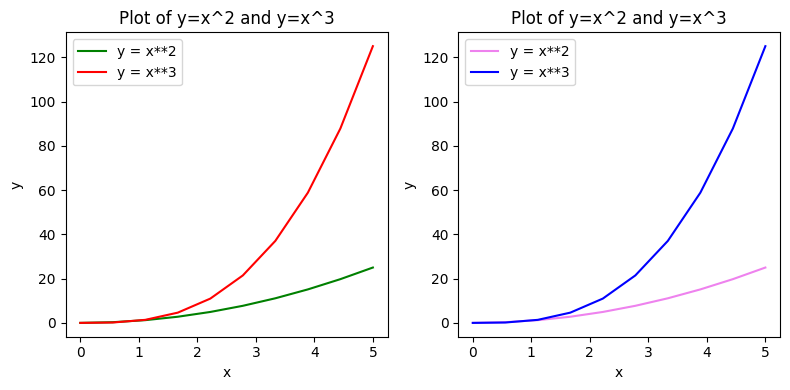

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
x = np.linspace(0, 5, 10)
y = x ** 2

fig, axes = plt.subplots(1, 2, figsize=(8,4), dpi=100)

# plot subplot 1
axes[0].plot(x, x**2, color="green", label="y = x**2")
axes[0].plot(x, x**3, color="red", label="y = x**3")
axes[0].legend(loc=2); # upper left corner
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Plot of y=x^2 and y=x^3')

# plot subplot 2
axes[1].plot(x, x**2, color="violet", label="y = x**2")
axes[1].plot(x, x**3, color="blue", label="y = x**3")
axes[1].legend(loc=2); # upper left corner
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Plot of y=x^2 and y=x^3')

# `fig.tight_layout()` automatically adjusts the positions of the axes on the figure canvas so that there is no overlapping content
# comment this out to see the difference
fig.tight_layout()

plt.show()